# 회귀분석

## 검증하고자 하는 것 : 맛집 프로그램별 SNS채널(네이버 블로그)에 미치는 영향력

### 분석계획 
### 1. 독립변수에 방송 프로그램 외 변수들을 추가하면서 R^2가 높아지는지 확인 & R^2가 가장 높은 회귀식 도출
### 2. 방송 프로그램별 회귀식을 만들어 포스팅 증가에 가장 영향을 미치는 요인 찾아보기
### *3. 70% 데이터(train set)로 회귀식을 만든 후, 30% 데이터(test set)로 예측해보고 정확도 확인*

In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('raw_data/reg_predict.csv')

In [3]:
df.head()

,식당,방송,방영전,방영후,증가,서울,방영월,방영년도
0,136생고기,생생정보,4,45,41,0,3,2017
1,3일한우국밥,생생정보,35,51,16,1,3,2018
2,가람떡갈비,맛있는녀석들,21,50,29,1,1,2018
3,가마솥 족발,생생정보,31,106,75,0,3,2018
4,가마솥손두부,생생정보,11,45,34,1,4,2018


## X : 방송(생생정보, 맛있는녀석들, 수요미식회),  방영전 포스팅 수, 서울(서울:1, 서울 외 지역:0), 계절(봄, 여름, 가을, 겨울)

## Y : 방영 후 포스팅 증감 수

## 1. 데이터 전처리

In [4]:
#봄(3-5월), 여름(6-8월), 가을(9-11월), 겨울(12-2월)
df.loc[(df['방영월']>2)&(df['방영월']<6), '계절'] = '봄'
df.loc[(df['방영월']>5)&(df['방영월']<9), '계절'] = '여름'
df.loc[(df['방영월']>8)&(df['방영월']<12), '계절'] = '가을'
df.loc[(df['방영월']<3)|(df['방영월']==12), '계절'] = '겨울'

In [5]:
df.head()

,식당,방송,방영전,방영후,증가,서울,방영월,방영년도,계절
0,136생고기,생생정보,4,45,41,0,3,2017,봄
1,3일한우국밥,생생정보,35,51,16,1,3,2018,봄
2,가람떡갈비,맛있는녀석들,21,50,29,1,1,2018,겨울
3,가마솥 족발,생생정보,31,106,75,0,3,2018,봄
4,가마솥손두부,생생정보,11,45,34,1,4,2018,봄


In [6]:
df['서울'] = df['서울'].astype('category')

In [7]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

In [8]:
dummy_columns = ['방송', '서울', '계절']

df = dummy_data(df, dummy_columns)
df.head()

,식당,방영전,방영후,증가,방영월,방영년도,방송_맛있는녀석들,방송_생생정보,방송_수요미식회,서울_0,서울_1,계절_가을,계절_겨울,계절_봄,계절_여름
0,136생고기,4,45,41,3,2017,0,1,0,1,0,0,0,1,0
1,3일한우국밥,35,51,16,3,2018,0,1,0,0,1,0,0,1,0
2,가람떡갈비,21,50,29,1,2018,1,0,0,0,1,0,1,0,0
3,가마솥 족발,31,106,75,3,2018,0,1,0,1,0,0,0,1,0
4,가마솥손두부,11,45,34,4,2018,0,1,0,0,1,0,0,1,0


In [9]:
def drop_not_concerned(data, columns):
    return data.drop(columns, axis=1)

not_concerned_columns = ["방영후", "방영월", "방송_수요미식회", "서울_0", "계절_봄"]

df_dummy = drop_not_concerned(df, not_concerned_columns)

In [10]:
df_dummy.head()

,식당,방영전,증가,방영년도,방송_맛있는녀석들,방송_생생정보,서울_1,계절_가을,계절_겨울,계절_여름
0,136생고기,4,41,2017,0,1,0,0,0,0
1,3일한우국밥,35,16,2018,0,1,1,0,0,0
2,가람떡갈비,21,29,2018,1,0,1,0,1,0
3,가마솥 족발,31,75,2018,0,1,0,0,0,0
4,가마솥손두부,11,34,2018,0,1,1,0,0,0


In [11]:
df_dummy.columns

Index(['식당', '방영전', '증가', '방영년도', '방송_맛있는녀석들', '방송_생생정보', '서울_1', '계절_가을',
       '계절_겨울', '계절_여름'],
      dtype='object')

## train set으로 회귀모형 만들기

### 모형 : 증가(y) ~ 방송_맛있는녀석들(x1) + 방송_생생정보(x2) + 방영전(x3) + 계절_여름(x4) + 계절_가을(x5) + 계절_겨울(x6) + 서울_1(x7)

#### train set, test set 분류

In [12]:
independent_variables = df_dummy[['방송_맛있는녀석들', '방송_생생정보', '서울_1', '계절_가을',
       '계절_겨울', '계절_여름', '방영전']]

In [13]:
y = df_dummy['증가']

In [14]:
independent_variables.head()

,방송_맛있는녀석들,방송_생생정보,서울_1,계절_가을,계절_겨울,계절_여름,방영전
0,0,1,0,0,0,0,4
1,0,1,1,0,0,0,35
2,1,0,1,0,1,0,21
3,0,1,0,0,0,0,31
4,0,1,1,0,0,0,11


In [15]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, y, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(221, 7) (221,)
(96, 7) (96,)


In [16]:
X_train.head()

,방송_맛있는녀석들,방송_생생정보,서울_1,계절_가을,계절_겨울,계절_여름,방영전
47,0,0,0,0,1,0,12
33,0,1,1,0,0,0,1
227,0,0,1,0,0,0,32
156,1,0,1,1,0,0,300
230,1,0,0,1,0,0,3


#### 다중공선성 확인

In [17]:
X_train.corr()

,방송_맛있는녀석들,방송_생생정보,서울_1,계절_가을,계절_겨울,계절_여름,방영전
방송_맛있는녀석들,1.000000,-0.534206,0.066146,-0.044539,-0.053100,0.060811,0.149091
방송_생생정보,-0.534206,1.000000,-0.386346,0.011818,0.068476,-0.024814,-0.129329
서울_1,0.066146,-0.386346,1.000000,-0.097266,0.057413,0.025217,0.006724
계절_가을,-0.044539,0.011818,-0.097266,1.000000,-0.315753,-0.241327,0.153053
계절_겨울,-0.053100,0.068476,0.057413,-0.315753,1.000000,-0.298025,-0.073875
계절_여름,0.060811,-0.024814,0.025217,-0.241327,-0.298025,1.000000,-0.078599
방영전,0.149091,-0.129329,0.006724,0.153053,-0.073875,-0.078599,1.000000


변수들 사이에 강한 상관관계가 보이지 않으므로 다중공선성 문제는 없다고 봐도 무방함

## train set으로 회귀모형 만든 후 test set 예측

In [18]:
lm = linear_model.LinearRegression()

In [19]:
#train set으로 회귀모형
model = lm.fit(X_train, y_train)

In [ ]:
#test set 예측
predictions = lm.predict(X_test)

### 예측률 보기

#### 그래프로 나타내기

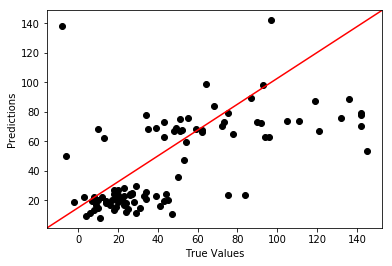

In [24]:
import matplotlib.lines as mlines

fig, ax = plt.subplots()
ax.scatter(y_test, predictions, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

예측을 잘 못한 것 같음..

#### 수치로 나타내기

In [25]:
print("Score: ", model.score(X_test, y_test))

Score:  0.3439679750833635


34%라니.. 충격...

**내가 생각한 예측률이 낮은 이유**
1. 데이터 갯수가 충분히 많지 않음
2. 독립변수 '방송 프로그램', '방영전 포스팅 갯수', '계절', '서울 여부'가 '방송 후 포스팅 증가분'을 설명하기에 적합하지 않거나 다른 독립변수가 더 필요